# Explore quantum models with a teacher-student scheme

This demonastration is based on the paper "The effect of the processing and measurement operators on the expressive power of quantum models" by <a href="https://arxiv.org/abs/2105.01477" title="link">Aikaterini (Katerina) Gratsea and Patrick Huembeli</a>.

The paper introduces tools to systematically explore the effect of the processing and measurement operators on the expressive power of simple quantum models. We use the averaged operator size, the map differencies from the Teacher-student scheme and the representation of quantum models as partial Fourier series inspired by the recent works of <a href="https://arxiv.org/abs/2011.07698" title="link">Y. Wu et. al.</a>, <a href="https://arxiv.org/abs/2105.01477" title="link"> A. Gratsea and P. Huembeli</a> and <a href="https://arxiv.org/abs/2105.01477" title="link"> Schuld et. al.</a>, respectively.

## Introduction

We express the quantum models as variational quantum circuits with encoding and proccesing gates along with a measurement.

Here, we choose a two dimensional input data set with $\vec{x}^k = ( x^k_1, x^k_2 )$ and encode the data to the circuit with the gates $U(\vec{x}) = R_x (x_1) \otimes R_x (x_2)$ applied on two distinct qubits, where $R_x(\phi) = \exp( -i\phi \sigma_x/2 )$ is the single qubit $X$ rotation gate. These data encoding gates are depicted in light and dark orange colors respectively in the circuit diagrams below and we will refer to it as the angle encoding. Throughout this work, we use the same encoding for all models to have a fair comparison. 

The trainable part of the perceptron is realized by parameterized single qubit rotations $ Rot(\phi, \theta, \omega) = R_z(\omega)R_y(\theta)R_z(\phi)$ and controlled-Z gates. At the output of each quantum model we apply a multi-controlled NOT gate inspired by <a href="https://www.nature.com/articles/s41534-019-0140-4" title="link"> Tacchino et. al.</a>. The trainable gates are depicted in blue colors in the following figures and we will refer to them as processing gates.


To train the quantum model, we define the cost function
\begin{equation}\label{cost_function}
    C = \sum_k{ \left( y^k - \bra{\psi^k} Z \ket{\psi^k} \right)^2 },
\end{equation}
which is minimized during the training.


$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

## 1. The averaged operator size

The averaged operator size is a quantity that depends on the circuit architecture, the processing unitaries and the measurement operators. Its value is positively correlated with the learning efficiency of the QNN architecture. To obtain the averaged operator size for a given circuit architecture $U_{\theta}$ and a fixed measurement $M$, we take the average over Haar random unitaries $U_{\theta}$

\begin{equation} \label{overlina_Size}
\overline{\operatorname{Size}}=\int d {U_{\theta}} \operatorname{Size}\left({U_{\theta}}^{\dagger} \hat{M}U_{\theta}\right). 
\end{equation}

The operator size $\operatorname{Size}(\hat{O})$ s given by

\begin{equation}
\operatorname{Size}(\hat{O})=\sum_{\boldsymbol{\alpha}}\left|c_{\boldsymbol{\alpha}}\right|^{2} l(\boldsymbol{\alpha}),
\end{equation}

where $c_{\boldsymbol{\alpha}}$ are the coefficients of decomposition of the Hermitian operator into a summation of Pauli strings and $l(\boldsymbol{\alpha})$ counts the number of non-identity matrices in each Kronecker product in the summation given by the same equation. A larger value of the average operator size suggests a more expressive circuit structure as explained in the work of <a href="https://arxiv.org/abs/2011.07698" title="link">Y. Wu et. al.</a>.

In this work, the Hermitian operator $\hat{O}$ that depends only on the processing $U_{\theta}$ and measurement $M$ operators is $\hat{O} =  U_{\theta}^{\dagger} {M} U_{\theta}$. 



We use the Monte Carlo numerical integration from <a href="https://jarrodmcclean.com/integrating-over-the-unitary-group/" title="link"> J. McClean: </a> for each arbritrary single qubit gate.

In [1]:
import numpy as np
import numpy.random
import scipy as sp
import scipy.linalg

def random_unitary(N):
    """Return a Haar distributed random unitary from U(N)"""
    Z = np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R] = sp.linalg.qr(Z)
    D = np.diag(np.diagonal(R) / np.abs(np.diagonal(R)))
    return np.dot(Q, D)

We define the Pauli Operators:

In [2]:
Pz = np.array([[1, 0], [0, -1]])
Px = np.array([[0, 1], [1, 0]])
Py =  np.array([[0, -1j], [1j, 0]])
Pi = np.array([[1, 0], [0, 1]])
list_Pauli = [Pz, Px, Py, Pi]

![alt text](qubit2_2gates.png "Title")

For the 2-qubit circuit from above, we introduce the CNOT and the measurement operator M:

In [3]:
CNOT = np.array([[1,0,0,0], [0,1,0,0], [0,0,0,1],[0,0,1,0]])
I2 = np.identity(2)
M = np.kron(I2, Pz)

In [4]:
points = 10000 # for numerical simulation
av_size = 0
n = 2 # qubits

list_av = [] 
for i in range(0, points):
    # Each arbitrary single qubit gate is drawn from the Haar random unitary function.
    U1 = random_unitary(2)
    U2 = random_unitary(2)
    U3 = random_unitary(2)
    U4 = random_unitary(2)
    U12 = np.kron(U1, U2)
    U34 = np.kron(U3, U4)

    # The Hermitian operator O is
    matrix1 = np.dot(U12, CNOT)
    matrix2 = np.dot(matrix1, U34)
    matrix3 = np.dot(matrix2, CNOT)
    matrix3H = np.matrix.getH(matrix3)

    step1 = np.dot(matrix3H, M)
    H = np.dot(step1, matrix3)

    # We define the Pauli kronecker products for each qubit
    list_Pauli1 = list_Pauli
    list_Pauli2 = list_Pauli

    list_kronsigma = []
    list_l = [] # l  denotes the number of matrices that are not identity. We have an Identity matrix for i=3 or j=3.
    for i in range(0, 4):
        for j in range(0, 4):
            list_kronsigma.append(np.kron(list_Pauli1[i], list_Pauli2[j]))
            l = 1
            if (i != 3 and j != 3 ):
                l = 2
            if (i == 3 and j == 3 ):
                l = 0
            list_l.append(l)

    # Then, we can compute the coefficients:
    list_coef = []
    for i in range(0, len(list_kronsigma)):
        new = np.dot(H, list_kronsigma[i])
        tr = np.matrix.trace(new)
        list_coef.append(tr/(2**n))
    Hprime = np.zeros((4,4), dtype = complex)
    for i in range(0, len(list_kronsigma)):
        Hprime += list_coef[i]*list_kronsigma[i]

    # And finally, the operator size
    size = 0
    for i in range(0, len(list_kronsigma)):
        l_alpha = list_l[i]
        size += l_alpha*np.abs(list_coef[i])**2
    list_av.append(size)
    
fmean = "{:.4f}".format(np.mean(list_av))
fstd = "{:.4f}".format(np.std(list_av)/np.sqrt(points-1))
print ("The mean is", fmean," with standart error ", fstd)

The mean is 1.5947  with standart error  0.0020


## 2. Map differencies

In [5]:
import pennylane as qml
from jax.config import config
config.update("jax_enable_x64", True)

import math
import jax
import jax.numpy as jnp
from pennylane import numpy as np

from jax import random
import matplotlib.pyplot as plt

####  For a detailed description of the teacher and student see the tutorial on "Explore quantum models with a teacher-student scheme" by Katerina Gratsea and Patrick Huembeli in the following Github repository <a href="{https://github.com/KaterinaGratsea/Teacher-student_scheme" title="link"> KaterinaGratsea/Teacher-student_scheme.</a>

In [6]:
def prediction_map(params, grid_resolution, qcircuit, rounded= False):
    #We create contour plots to visualize the teacher's and students' data sets.
    dec_map = np.zeros((grid_resolution, grid_resolution))
    x_line = np.linspace(-math.pi, math.pi , grid_resolution)
    X_grid, Y_grid = np.meshgrid(x_line, x_line)

    for i in range(grid_resolution):
        for j in range(grid_resolution):
            f = qcircuit(params, x=[x_line.tolist()[i], x_line.tolist()[j], 0])
            dec_map[j][i] = f
    dec_map1 = 2.*(dec_map - np.min(dec_map))/np.ptp(dec_map)-1
    
    if rounded == True:
        dec_map = np.sign(dec_map)
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cont = ax.contourf(X_grid, Y_grid, dec_map1, 20, cmap='magma')
#     plt.colorbar(cont)
    return (dec_map1)

## Circuit Teacher

In [7]:
dev = qml.device("default.qubit", wires=3)
#The quantum circuit of the teacher (the re-uploading quantum model).
def qcircuit_teacher(params, x=None):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.Rot(*params[0], wires=0)
    qml.Rot(*params[1], wires=1)
    qml.Toffoli(wires=[0,1,2])
    return qml.expval(qml.PauliZ(2))

## Circuit Student

In [8]:
dev_student = qml.device("default.qubit.jax", wires=3)
@qml.qnode(dev_student, interface="jax")
def qcircuit_student(params, x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.Rot(*params[0], wires=0)
    qml.Rot(*params[1], wires=1)
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(1))

In [9]:
#number of processing gates for the teacher and the students
nr_of_gates_teacher = 2
nr_of_gates = 2

trainings = 100 #number of data points
inputs = 500

In [10]:
key = random.PRNGKey(1)

In [11]:
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(4)):
    #Data points inside and outside a given radius with the labels 1 and -1, respectively.
    dataX, dataY = [], []

    for i in range(samples):
        x = 2 * math.pi * (np.random.rand(2)) - math.pi
        y = 1
        if np.linalg.norm(x - center) < radius:
            y = -1
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

In [12]:
@jax.jit
def loss(params, x_train, y_train):
    y_pred = f_vmap(params, x_train)
    return ((y_pred - y_train)**2).mean()

In [13]:
def pos_function(nr_of_gates_teacher, inputs):
    positivity = 0.8
    while (positivity >= 0.8):
        positivity = 0
        #Define random parameters for the proccessing gates of the teacher.
        params_teacher = 2*np.pi*np.random.rand(nr_of_gates_teacher, 3)

        #The proccessing gates change the circular data-set to a more complex one.
        X_train, y_train = circle(inputs)

        list_labels = []
        for i in range (0, inputs):
            list_labels.append(qnode_teacher(params_teacher, x=X_train[i]))
            if (list_labels[i] >= 0) :
                positivity += 1
        positivity /= inputs
        return (list_labels)

In [14]:
#Set a random seed
np.random.seed(40)

average = 0
points = 10
for training in range(0, trainings):
    params_teacher = 2*np.pi*np.random.rand(nr_of_gates_teacher, 3)
    qnode_teacher = qml.QNode(qcircuit_teacher, dev)
    
    #Guarantess that the number of labels "1" are less than 80%.
    list_labels = pos_function(nr_of_gates_teacher, inputs)

    teacher_y_train = np.tensor(list_labels)
    mapT = prediction_map(params_teacher, points, qnode_teacher)
    
    
    #TRAIN STUDENT

    X_train, teacher_y_train = circle(inputs)
    
    x_train = jnp.array(X_train)
    y_train = jnp.array(teacher_y_train)
    
    key, subkey = random.split(key)
    param_student = jax.random.uniform(subkey, (nr_of_gates, 3))

    f_vmap = jax.vmap(qcircuit_student, in_axes = (None,0))

    grad_loss = jax.jit(jax.grad(loss, argnums=0))
    total_steps = 500
    steps = list(range(total_steps))
    for _ in range(total_steps):
        param_student -= grad_loss(param_student, x_train, y_train) 
    
    mapS = prediction_map(param_student, points, qcircuit_student)

    av_dif = 0
    for i in range(points):
        for j in range(points):
            diff = np.abs(mapT[i][j] - mapS[i][j])
            av_dif += diff
    av_dif /= points*points
    average += av_dif
average /= points*points
av = average*100
format_average = "{:.2f}".format(av)
print (format_average)

73.42


In [15]:
print (" The 2-qubit student circuit is approximately ",format_average,"% off from the desired target distributions of the 3-qubit teacher.")

 The 2-qubit student circuit is approximately  73.42 % off from the desired target distributions of the 3-qubit teacher.


## 3. Fourier coefficients

In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import spectrum
import math

from pennylane.fourier.visualize import *
import matplotlib.pyplot as plt

from pennylane.fourier import coefficients
from functools import partial

dev = qml.device('default.qubit', wires=2)

#### Finally, we plot the real and imaginary part of the Fourier coefficients of the 2-qubit student circuit.

array([[<AxesSubplot:title={'center':'0, 0'}>,
        <AxesSubplot:title={'center':'0, 1'}>,
        <AxesSubplot:title={'center':'0, -1'}>],
       [<AxesSubplot:title={'center':'1, 0'}>,
        <AxesSubplot:title={'center':'1, 1'}>,
        <AxesSubplot:title={'center':'1, -1'}>],
       [<AxesSubplot:title={'center':'-1, 0'}>,
        <AxesSubplot:title={'center':'-1, 1'}>,
        <AxesSubplot:title={'center':'-1, -1'}>]], dtype=object)

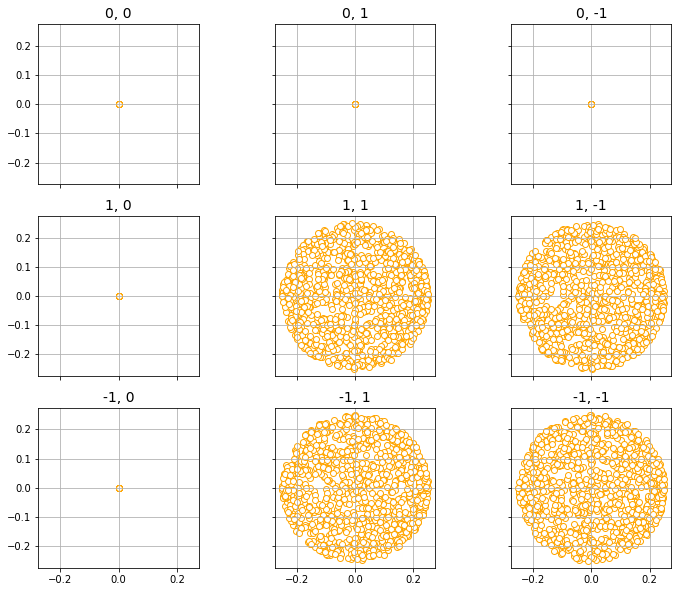

In [17]:
coeffs1 = []

for _ in range(1000):
    params_teacher = 2*np.pi*np.random.rand(nr_of_gates, 3)   
    c = coefficients(partial(qcircuit_student, params_teacher), 2, degree=1)
    coeffs1.append(np.round(c, decimals=8))

fig, ax = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
panel(coeffs1, 2, ax, colour="orange")